In [ ]:
!pip install pymc_marketing==0.2.2

In [45]:
import warnings #Pythonでの警告メッセージを制御するためのライブラリ
import arviz as az #統計モデルの診断と可視化のためのライブラリ
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm #ベイズモデリングのためのライブラリ
import seaborn as sns
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation #幾何学的アドストック関数とロジスティック飽和関数をインポート
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM #MMMで使用する関数

warnings.filterwarnings("ignore") #Pythonの警告メッセージを表示しないように設定
az.style.use("arviz-darkgrid") #arvizのデフォルトスタイルを "arviz-darkgrid"に設定
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
rng: np.random.Generator = np.random.default_rng(seed=1) #乱数生成の再現性を保証するためにシードを1に設定

# データの期間（週次データを使用）
min_date = pd.to_datetime("2020-04-01") #最小日付を2020年4月1日に設定
max_date = pd.to_datetime("2023-09-01") #最大日付を2023年9月1日に設定

# 指定された期間の週次データを含むデータフレームを作成し、年、月、日の情報を追加
df = pd.DataFrame(
data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 178


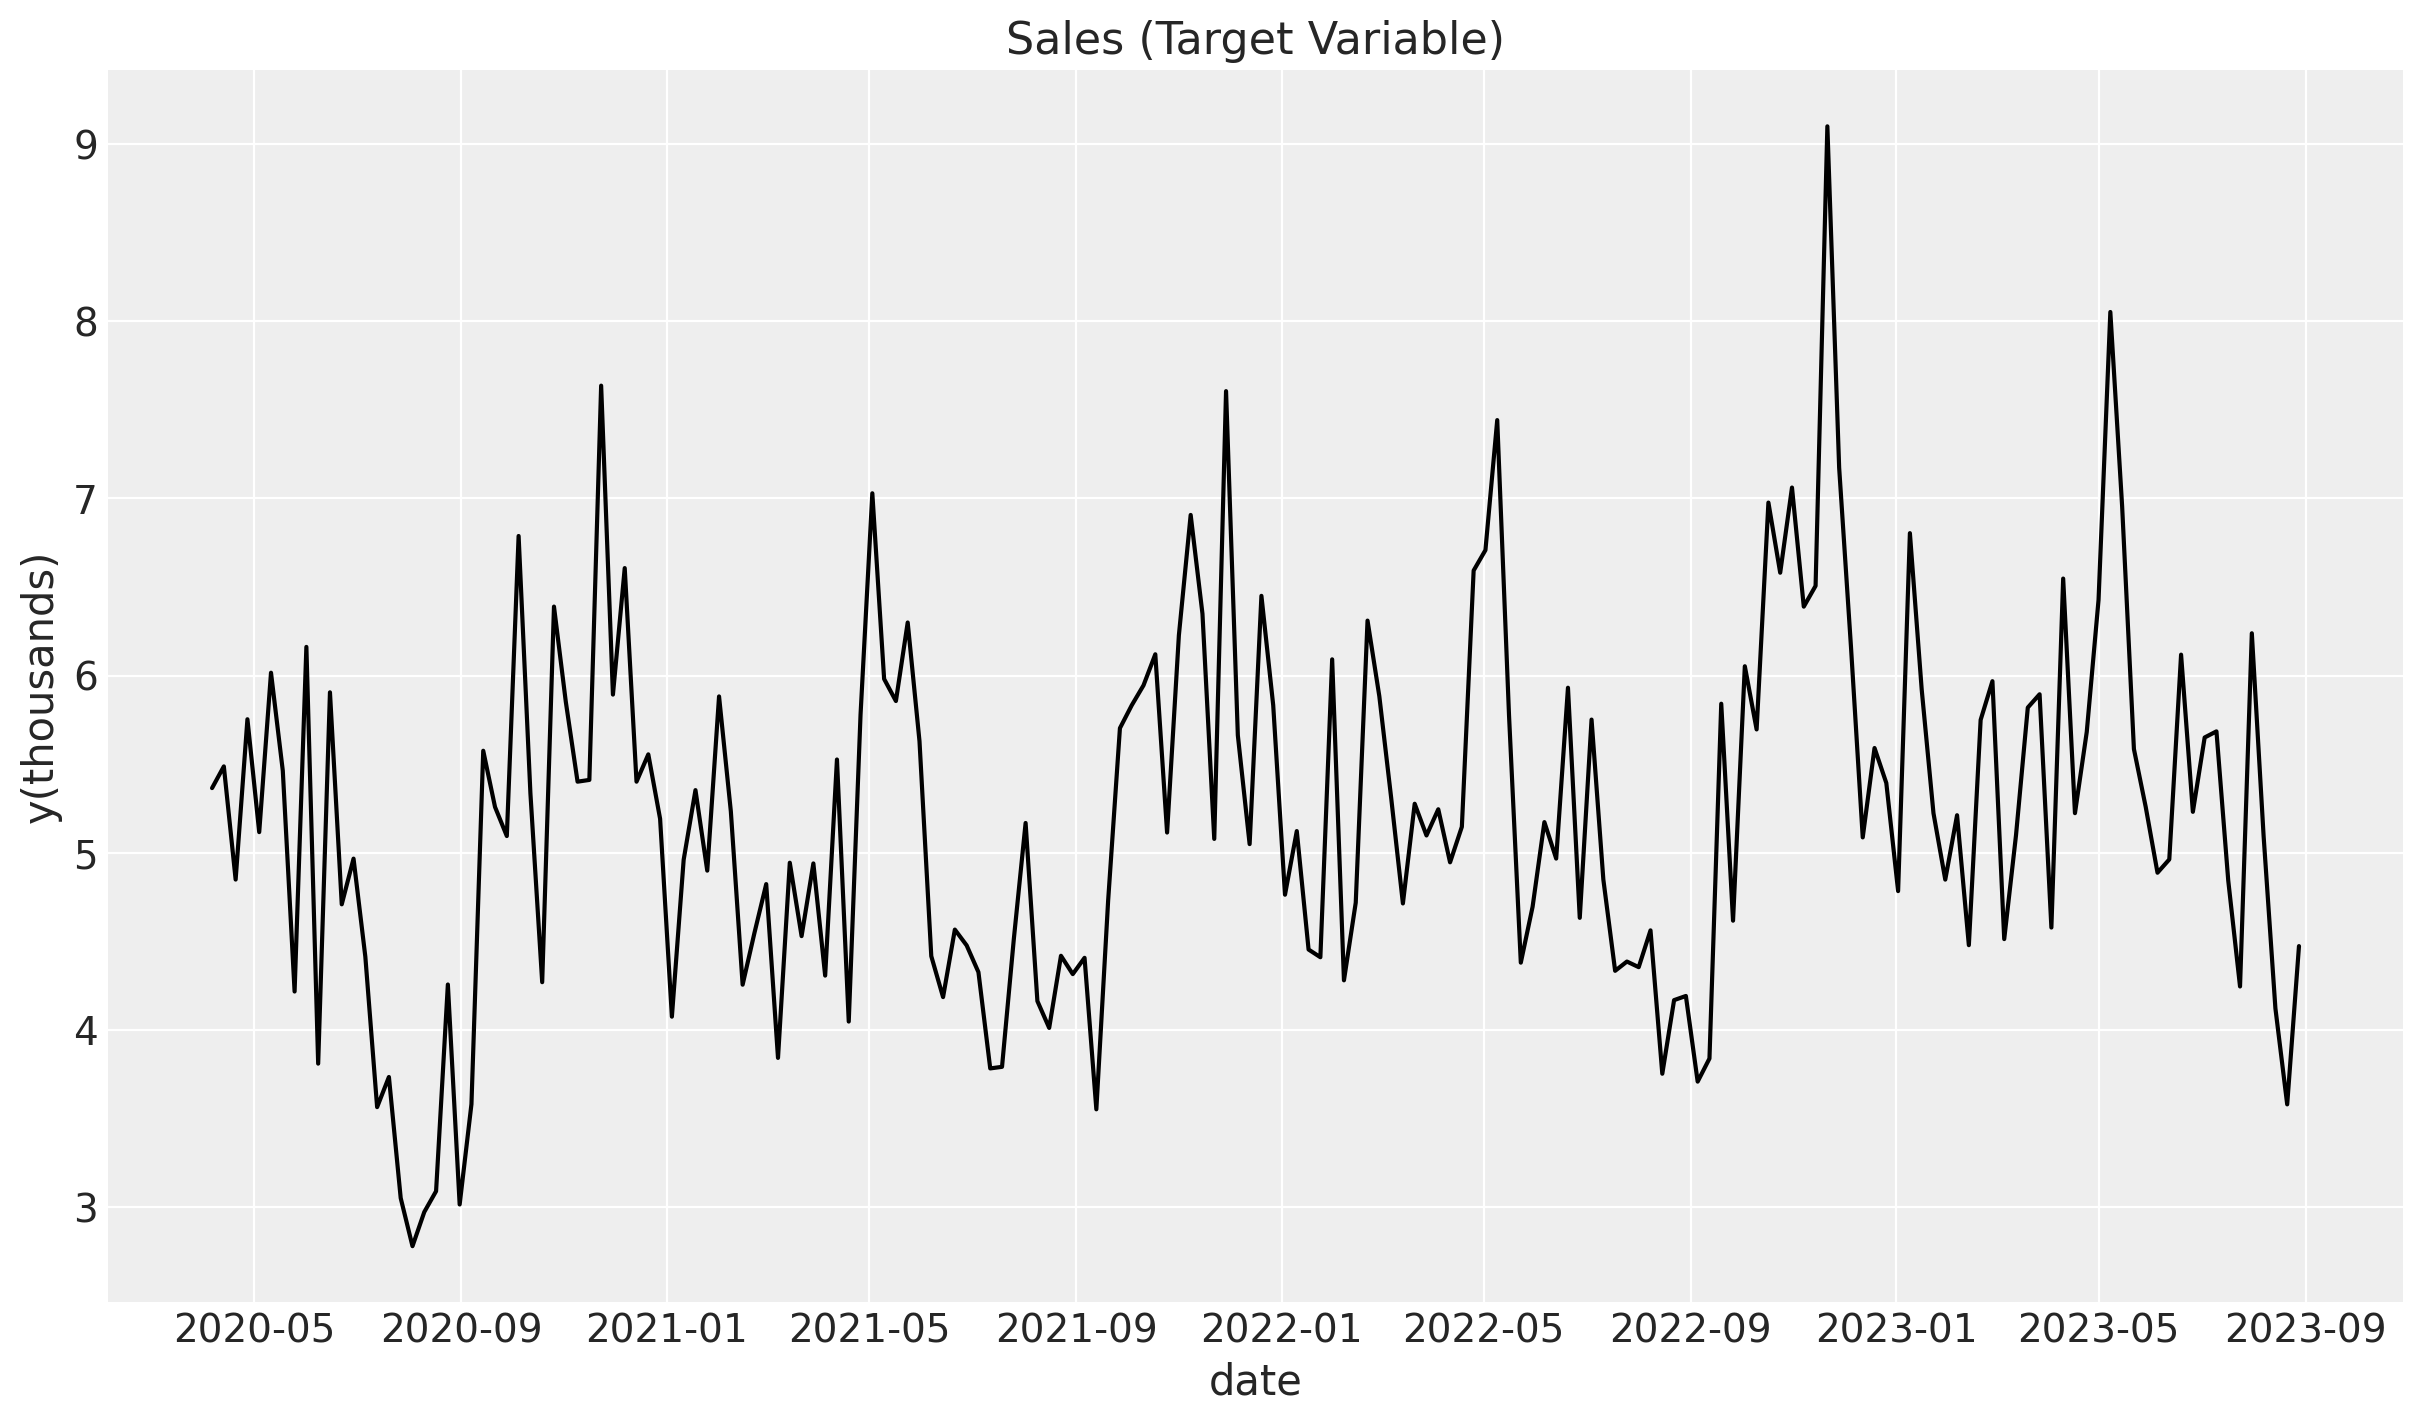

In [47]:
tv = rng.uniform(low=0.0, high=1.0, size=n) #一様分布からランダムなTVデータを生成
df["tv"] = np.where(tv > 0.9, tv, tv / 2) #TVの広告費データをデータフレームに追加し、一定の条件に基づいて値を変更
web = rng.uniform(low=0.0, high=1.0, size=n) #同様に、一様分布からランダムなWebの広告費データを生成
df["web"] = np.where(web > 0.8, web, 0) #Webデータをデータフレームに追加し、一定の条件に基づいて値を変更

# アドストック用のパラメータを設定
alpha1: float = 0.4
alpha2: float = 0.2

#TVとWebデータに対してアドストック効果に基づく変換を適用
df["tv_adstock"] = (geometric_adstock(x=df["tv"].to_numpy(), alpha=alpha1, l_max=8,normalize=True).eval().flatten())
df["web_adstock"] = (geometric_adstock(x=df["web"].to_numpy(), alpha=alpha2, l_max=8,normalize=True).eval().flatten())

# 形状パラメータを設定
lam1: float = 4.0
lam2: float = 3.0

# TVとWebのアドストックデータに対して形状効果に基づく変換を適用
df["tv_adstock_saturated"] = logistic_saturation(
    x=df["tv_adstock"].to_numpy(), lam=lam1
    ).eval()
df["web_adstock_saturated"] = logistic_saturation(
    x=df["web_adstock"].to_numpy(), lam=lam2
    ).eval()

# トレンド項をデータフレームに追加
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

# 季節項の計算を行い、データフレームに追加
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"]) #季節項

# イベント項、切片、誤差項をデータフレームに追加
df["event_1"] = (df["date_week"] == "2021-05-13").astype(float) #イベント項①
df["event_2"] = (df["date_week"] == "2022-09-14").astype(float) #イベント項②
df["intercept"] = 2.0 #切片
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)#誤差項

# TVとWebの効果の係数をサンプルデータ生成のために設定
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]

# 売上データの生成
df["y"] = df["intercept"] + df["trend"] + df["seasonality"] + 1.5 * df["event_1"] + 2.5 * df["event_2"] + beta_1 * df["tv_adstock_saturated"] + beta_2 * df["web_adstock_saturated"] + df["epsilon"]

# 売上データの可視化
fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y(thousands)");

In [48]:
contribution_share_tv: float = (beta_1 * df["tv_adstock_saturated"]).sum() / (beta_1 * df["tv_adstock_saturated"] + beta_2 * df["web_adstock_saturated"]).sum()
contribution_share_web: float = (beta_2 * df["web_adstock_saturated"]).sum()/ (beta_1 * df["tv_adstock_saturated"] + beta_2 * df["web_adstock_saturated"]).sum()
print(f"Contribution Share of tv: {contribution_share_tv:.2f}")
print(f"Contribution Share of web: {contribution_share_web:.2f}")

Contribution Share of tv: 0.81
Contribution Share of web: 0.19


In [49]:
roas_tv = (beta_1 * df["tv_adstock_saturated"]).sum() / df["tv"].sum()
roas_web = (beta_2 * df["web_adstock_saturated"]).sum() / df["web"].sum()
print(f"Roas of tv: {roas_tv:.2f}")
print(f"Roas of web: {roas_web:.2f}")

Roas of tv: 5.05
Roas of web: 2.31


In [50]:
columns_to_keep = [
    "date_week",
    "y",
    "tv",
    "web",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
data["t"] = range(n) #番号の設定(後でトレンド項として使用)

In [51]:
total_spend_per_channel = data[["tv", "web"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

tv     0.660494
web    0.339506
dtype: float64

In [52]:
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
n_channels = 2 #チャネル数
prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy() #事前分布の標準偏差
prior_sigma.tolist()

[2.191381255707321, 1.126412224233291]

In [53]:
X = data.drop("y",axis=1)
y = data["y"]

In [54]:
dummy_model = DelayedSaturatedMMM(date_column = "", channel_columns = "",adstock_max_lag = "")
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

In [55]:
custom_beta_channel_prior = {"beta_channel": {"sigma": prior_sigma, "dims":("channel",)}}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}
sampler_config= {"progressbar": True}

In [56]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["tv", "web"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
        ],
    adstock_max_lag=8, #アドストックの最大ラグ(遅延)を8時点に設定
    yearly_seasonality=2, #1年間で1サイクルの季節性をモデル化(数値を大きくすることでより複雑な季節性を表現可能)
)
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

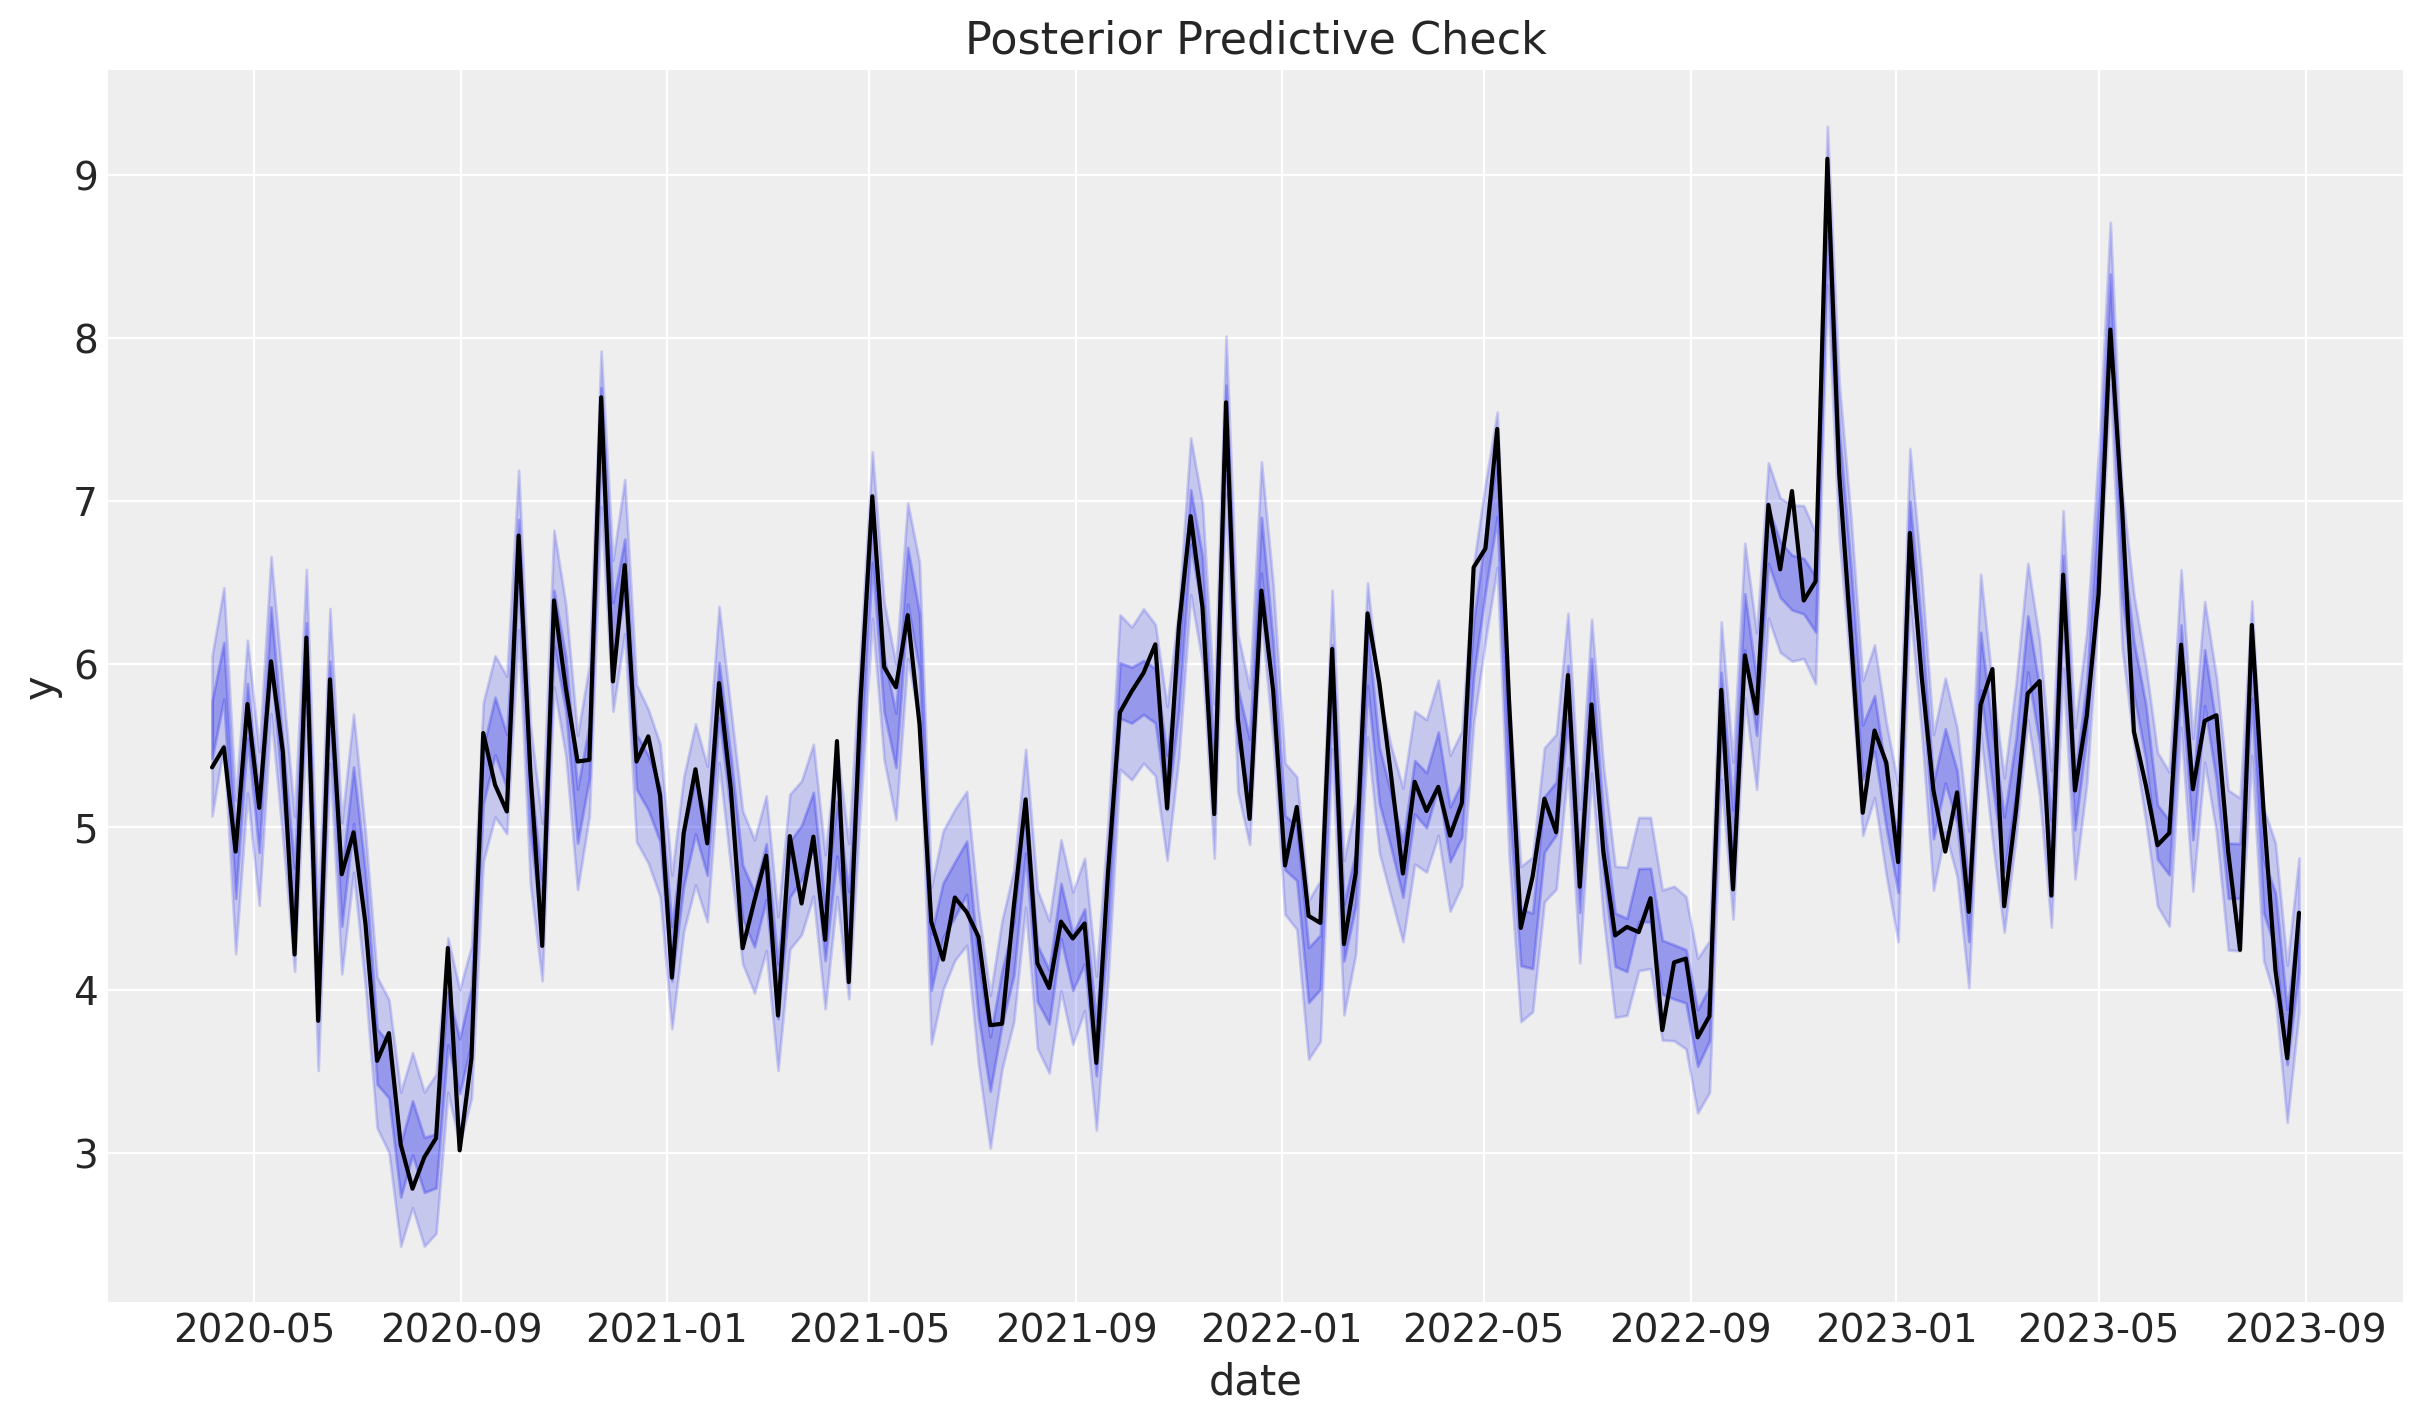

In [57]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)
mmm.plot_posterior_predictive(original_scale=True);

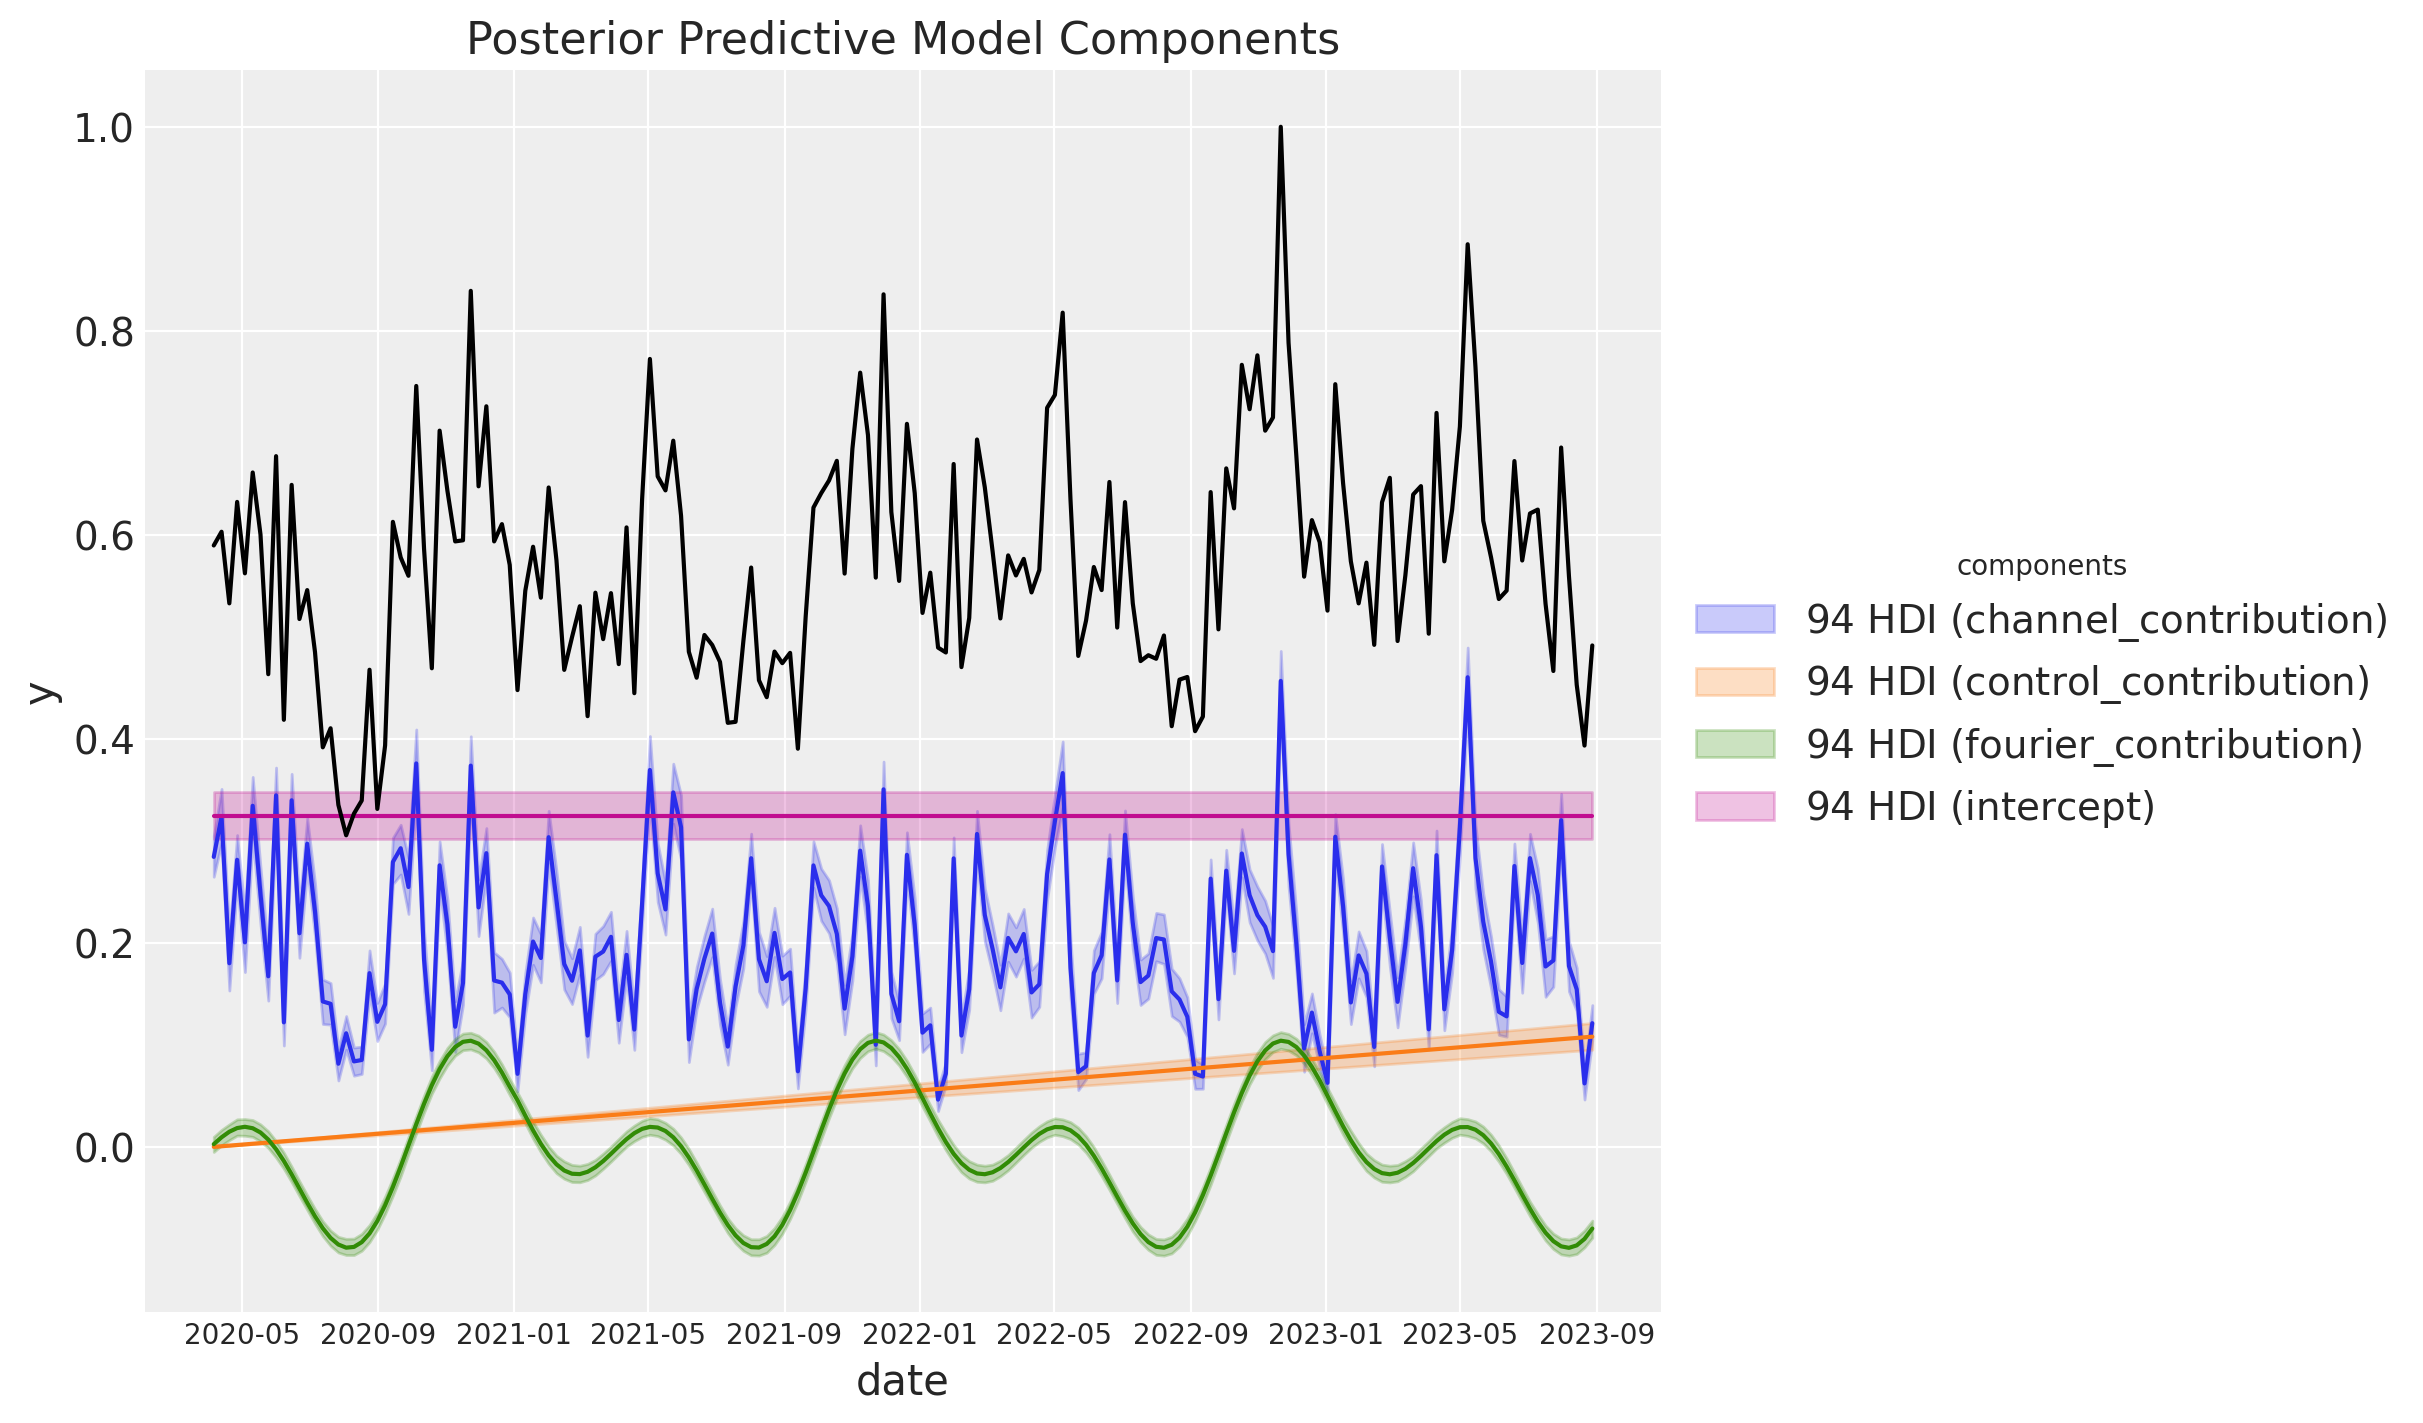

In [58]:
mmm.plot_components_contributions();
plt.tick_params(axis='x', which='major', labelsize=10)

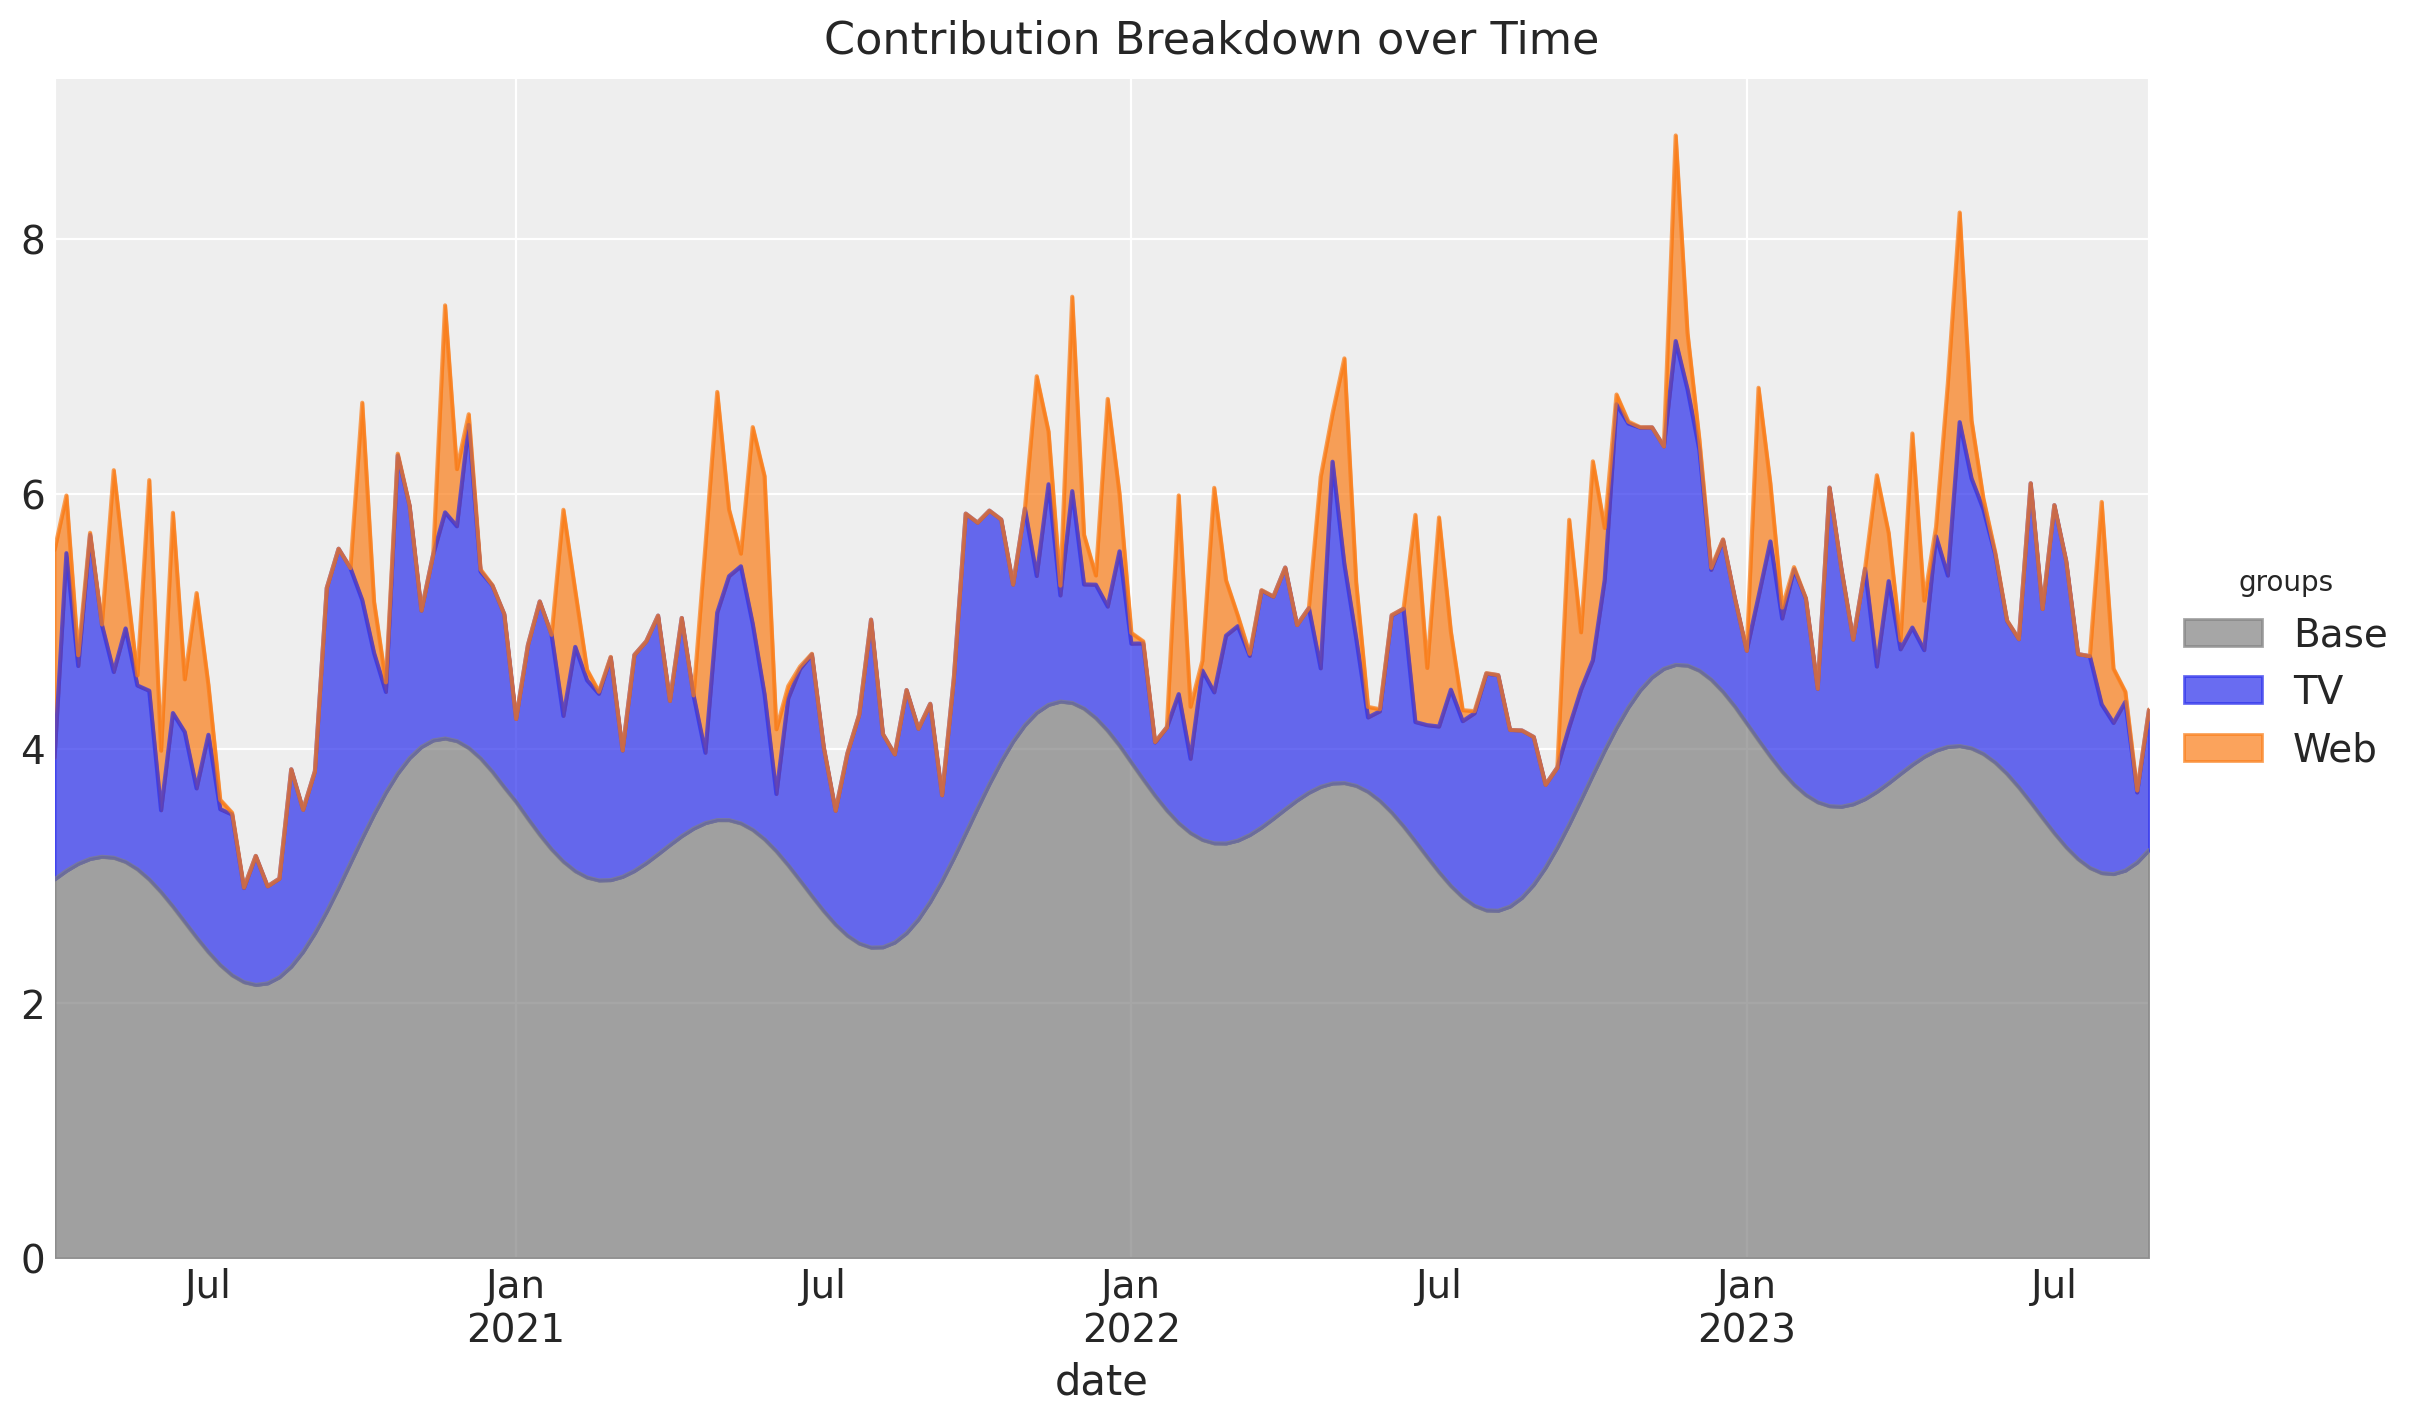

In [59]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
        ],
    "TV": ["tv"],
    "Web": ["web"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "TV": "C0",
            "Web": "C1",
            "Base": "gray",
            "Seasonality": "black",
            },
        "alpha": 0.7,
        },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

In [60]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(original_scale=True)

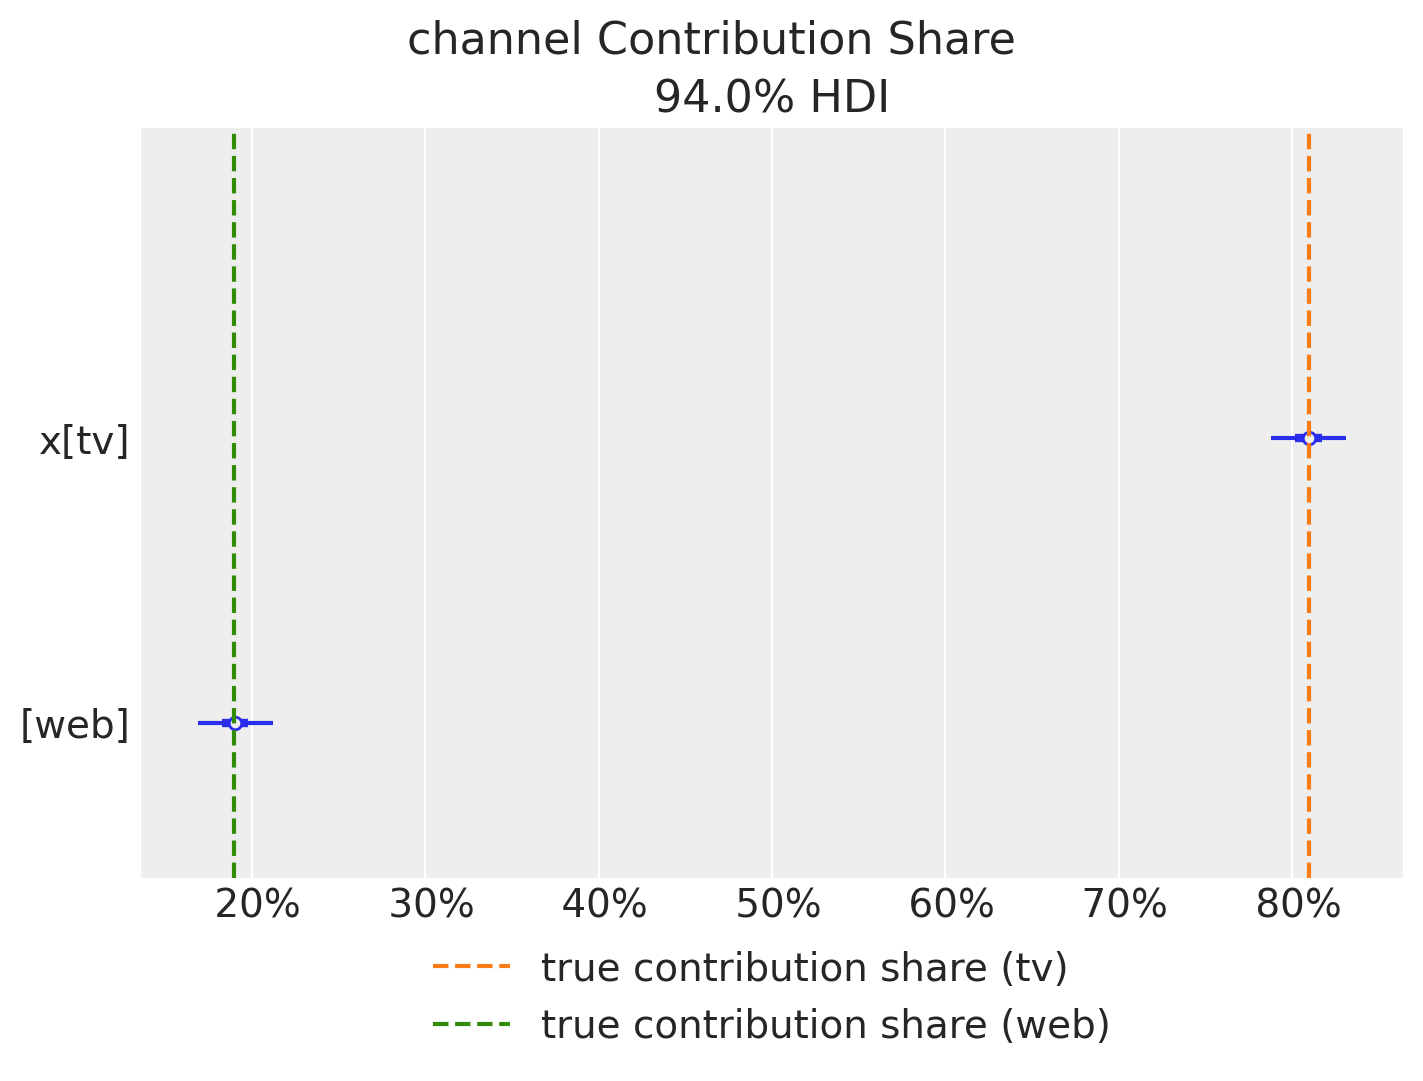

In [61]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_tv,
    color="C1",
    linestyle="--",
    label="true contribution share (tv)",
)
ax.axvline(
    x=contribution_share_web,
    color="C2",
    linestyle="--",
    label="true contribution share (web)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

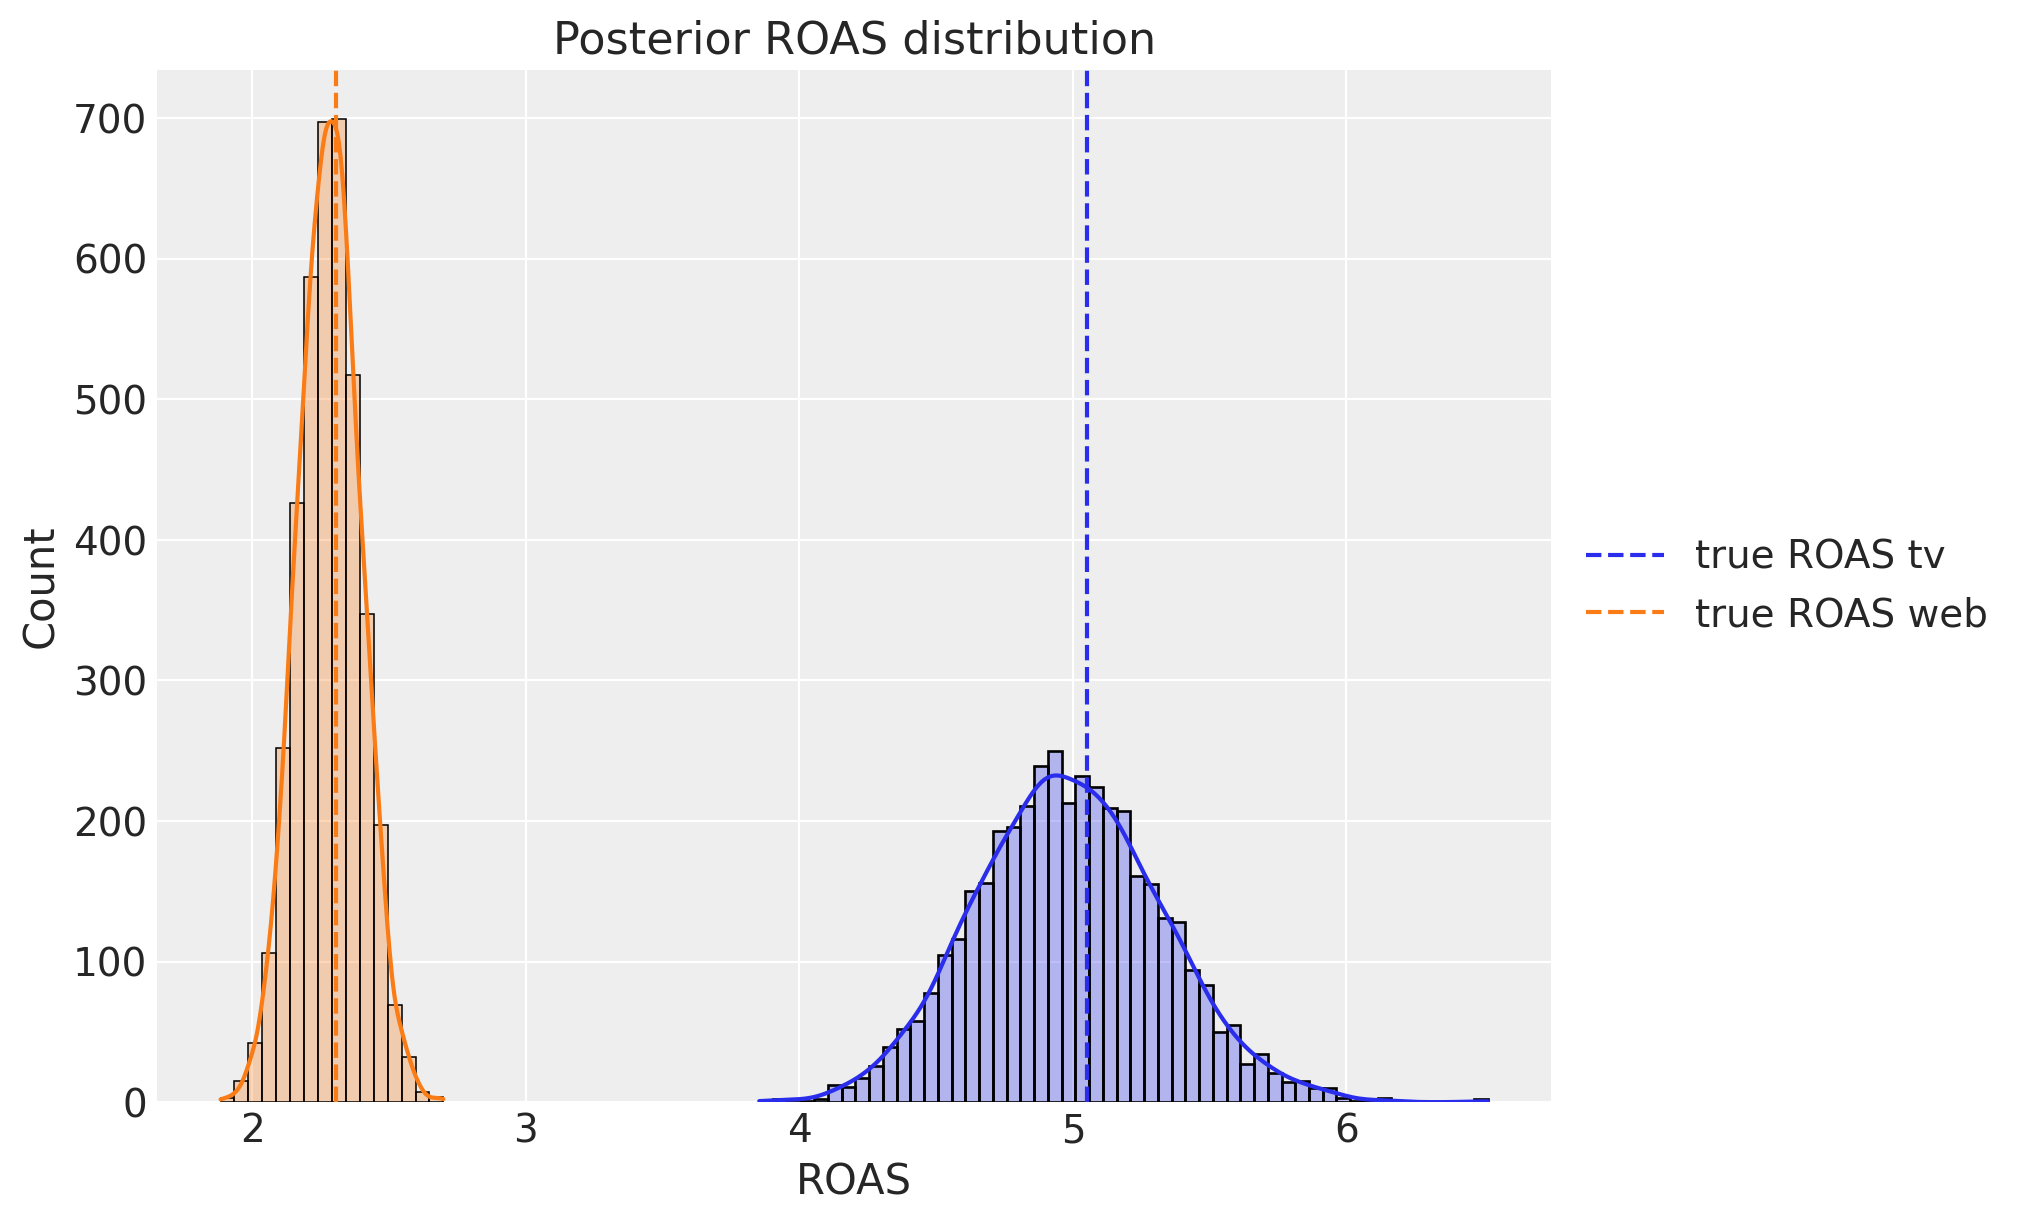

In [62]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
roas_samples = (channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")/data[["tv", "web"]].sum().to_numpy()[..., None])
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
roas_samples.sel(channel="tv").to_numpy(), binwidth=0.05, alpha=0.3,
kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="web").to_numpy(), binwidth=0.05, alpha=0.3,kde=True, ax=ax
)
ax.axvline(x=roas_tv, color="C0", linestyle="--", label=r"true ROAS tv")
ax.axvline(x=roas_web, color="C1", linestyle="--", label=r"true ROAS web")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");